In [18]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic, SVD
from sklearn.metrics import mean_squared_error

# Load cleaned data
df = pd.read_csv(r'D:\DATA SCIENCE\Amazon Data Set\preprocessed_amazon_reviews.csv', 
                parse_dates=['Time'],
                dtype={'UserId': 'str', 'ProductId': 'str'})

print(f"Initial data: {len(df):,} reviews")
print(f"Time range: {df['Time'].min().date()} to {df['Time'].max().date()}")

Initial data: 219,540 reviews
Time range: 2000-08-09 to 2012-10-26


In [20]:
# TEMPORAL SPLIT 
df = df.sort_values('Time')
split_idx = int(0.7 * len(df))
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

print(f"Train: {len(train):,} reviews ({train['Time'].max().date()})")
print(f"Test:  {len(test):,} reviews ({test['Time'].min().date()} onward)")
print(f"Unique users - Train: {train['UserId'].nunique():,}, Test: {test['UserId'].nunique():,}")

Train: 153,678 reviews (2012-01-23)
Test:  65,862 reviews (2012-01-23 onward)
Unique users - Train: 18,825, Test: 10,700


In [22]:
# MODEL TRAINING 
from surprise import accuracy

# Collaborative Filtering (User-Based)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(train[['UserId','ProductId','Score']], reader)
algo_cf = KNNBasic(sim_options={'user_based': True})
algo_cf.fit(data.build_full_trainset())

# Matrix Factorization (SVD)
algo_mf = SVD()
algo_mf.fit(data.build_full_trainset())

# Add predictions to test data
test['Pred_CF'] = [algo_cf.predict(uid, iid).est for uid, iid in zip(test['UserId'], test['ProductId'])]
test['Pred_MF'] = [algo_mf.predict(uid, iid).est for uid, iid in zip(test['UserId'], test['ProductId'])]

print("✓ Models trained")

Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\3809980225.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Pred_CF'] = [algo_cf.predict(uid, iid).est for uid, iid in zip(test['UserId'], test['ProductId'])]


✓ Models trained


C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\3809980225.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Pred_MF'] = [algo_mf.predict(uid, iid).est for uid, iid in zip(test['UserId'], test['ProductId'])]


In [24]:
# BASE MODEL RESULTS
def precision_at_k(df, model_col, k=10, relevance_threshold=4):
    # Rank items for each user
    df['Rank'] = df.groupby('UserId')[model_col].rank(ascending=False)
    # Filter top-k items
    top_k = df[df['Rank'] <= k]
    # Calculating precision (fraction of relevant items)
    precision = (top_k['Score'] >= relevance_threshold).mean()
    return precision

# RMSE Calculations
rmse_cf = np.sqrt(mean_squared_error(test['Score'], test['Pred_CF']))
rmse_mf = np.sqrt(mean_squared_error(test['Score'], test['Pred_MF']))

# Precision@10 Calculation
precision_cf = precision_at_k(test, 'Pred_CF', k=10)
precision_mf = precision_at_k(test, 'Pred_MF', k=10)

print(f"""
Collaborative Filtering:
- RMSE: {rmse_cf:.3f}
- Precision@10: {precision_cf:.3f}

Matrix Factorization:
- RMSE: {rmse_mf:.3f}
- Precision@10: {precision_mf:.3f}
""")


Collaborative Filtering:
- RMSE: 1.282
- Precision@10: 0.757

Matrix Factorization:
- RMSE: 1.236
- Precision@10: 0.761



C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\237021939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rank'] = df.groupby('UserId')[model_col].rank(ascending=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\237021939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rank'] = df.groupby('UserId')[model_col].rank(ascending=False)


In [26]:
# HYBRID MODEL
from nltk.sentiment import SentimentIntensityAnalyzer

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
test['Sentiment'] = test['CleanText'].apply(lambda x: sia.polarity_scores(x)['compound'])
test['SentimentScore'] = np.interp(test['Sentiment'], [-1,1], [1,5])

# Hybrid Scoring
test['HybridScore'] = 0.6*test['Pred_CF'] + 0.3*test['SentimentScore'] + 0.1*test['HelpfulnessRatio']

C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\2435952095.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sentiment'] = test['CleanText'].apply(lambda x: sia.polarity_scores(x)['compound'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\2435952095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SentimentScore'] = np.interp(test['Sentiment'], [-1,1], [1,5])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\2435952095.py:10: SettingWithCopyWarning: 
A value is trying to be set on a c

In [27]:
# HYBRID RESULTS
hybrid_rmse = np.sqrt(mean_squared_error(test['Score'], test['HybridScore']))
hybrid_precision = precision_at_k(test, 'HybridScore', k=10)

print(f"""
Hybrid Model (CF + Sentiment):
- RMSE: {hybrid_rmse:.3f} ({'↑' if hybrid_rmse>rmse_cf else '↓'} vs CF)
- Precision@10: {hybrid_precision:.3f} ({'↑' if hybrid_precision>precision_cf else '↓'} vs CF)
""")


Hybrid Model (CF + Sentiment):
- RMSE: 1.215 (↓ vs CF)
- Precision@10: 0.761 (↑ vs CF)



C:\Users\Admin\AppData\Local\Temp\ipykernel_20436\237021939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rank'] = df.groupby('UserId')[model_col].rank(ascending=False)


In [30]:
# COLD-START ANALYSIS
cold_users = test[~test['UserId'].isin(train['UserId'])]

print(f"Cold-start users: {len(cold_users):,}/{len(test):,} ({len(cold_users)/len(test):.1%})")

# CF Performance
cf_cold_rmse = np.sqrt(mean_squared_error(cold_users['Score'], cold_users['Pred_CF']))

# Hybrid Performance
hybrid_cold_rmse = np.sqrt(mean_squared_error(cold_users['Score'], cold_users['HybridScore']))

print(f"""
Cold-Start RMSE:
- CF Only:     {cf_cold_rmse:.3f}
- Hybrid:      {hybrid_cold_rmse:.3f} ({'↑' if hybrid_cold_rmse>cf_cold_rmse else '↓'})
""")

Cold-start users: 33,061/65,862 (50.2%)

Cold-Start RMSE:
- CF Only:     1.324
- Hybrid:      1.274 (↓)



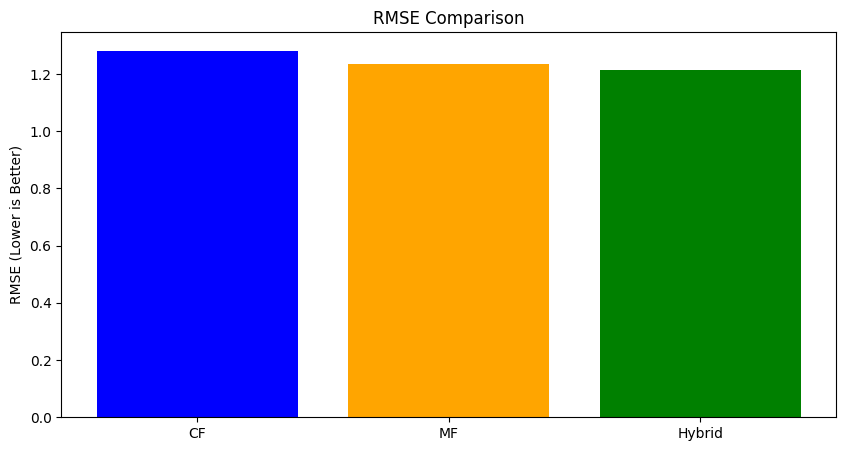

In [32]:
# VISUALIZATION
import matplotlib.pyplot as plt

models = ['CF', 'MF', 'Hybrid']
rmse_values = [rmse_cf, rmse_mf, hybrid_rmse]

plt.figure(figsize=(10,5))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.show()